In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad,dblquad,tplquad,quadrature,romberg
from scipy.stats import norm,lognorm,entropy
import scipy.stats as sstats
import scipy.special as sc
from itertools import accumulate
from time import time
from scipy.signal import savgol_filter

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from suppressedBD import *
from forecasting import *

# Generate testing data

In [16]:
# PARAMETER DEFINITION
beta = 0.97
gamma = 2.3
N = 10
Tmax = 25
nframes = 80
trange = np.linspace(0,Tmax,nframes)

In [17]:
Fs, js = generateHistories(trange,beta,gamma,N,Nsims = 20000)

100%|████████████████████████████████████| 20000/20000 [01:08<00:00, 291.37it/s]


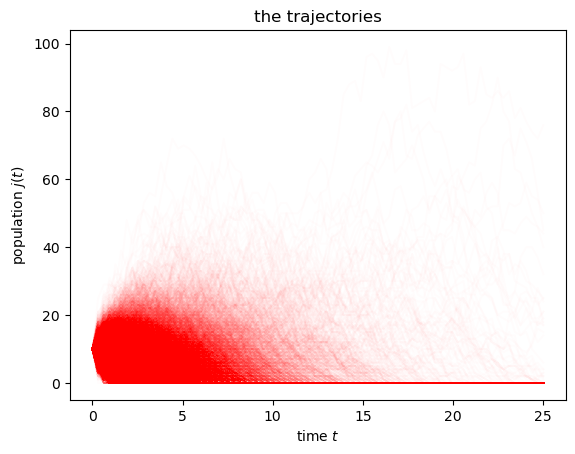

In [18]:
for j in js:
    plt.plot(trange,j(trange),color = 'red',alpha = 0.01)
plt.title("the trajectories")
plt.xlabel(r"time $t$")
plt.ylabel(r"population $j(t)$")
plt.show()

### get distributions from synthetic data

In [19]:
# generate distribution info from test data
cumulant_data = {'j':[],'F':[],'oj':[],'oF':[],'cov':[]}
full_data = [{'jv':[],'jd':[],'fv':[],'fd':[]} for t in trange]

for i in tqdm(range(len(trange))): 
    t = trange[i]
    
    jdist = np.array([int(j(t)) for j in js])
    fdist = np.array([int(F(t)) for F in Fs])
    
    jvals = np.arange(1,max(jdist)+1)
    jcounts = np.bincount(jdist)
    full_data[i]['jv'] = jvals
    full_data[i]['jd'] = jcounts[1:]/sum(jcounts)
    
    fvals = np.arange(max(fdist)+1)
    fcounts = np.bincount(fdist)
    full_data[i]['fv'] = fvals
    full_data[i]['fd'] = fcounts/sum(fcounts)
    
    # cumulant data
    cumulant_data['j'] += [np.mean(jdist)]
    cumulant_data['F'] += [np.mean(fdist)]
    
    cmat = np.cov(jdist,fdist)
    
    cumulant_data['cov'] += [cmat[0,1]]
    
    cumulant_data['oj'] += [cmat[0,0]]
    cumulant_data['oF'] += [cmat[1,1]]
      

100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.62it/s]


# Population distributions

### Animated population distribution

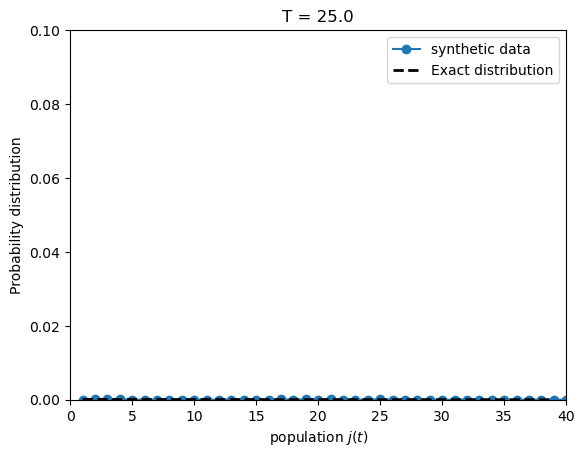

In [20]:
# Set up the figure, the axis, and the plot elements
fig, ax = plt.subplots()

xdata = full_data[0]['jv']
ydata = full_data[0]['jd']

ln, = plt.plot(xdata, ydata,marker = 'o',label = 'synthetic data');

jjj = np.arange(1,40)
fit, = plt.plot(jjj, [physP(N,j,0.001,beta,gamma+0.001) for j in jjj],'k--', lw=2, label='Exact distribution'.format(0))
ax.set_title("T = 0")
ax.set_xlabel(r"population $j(t)$")
ax.set_ylabel(r"Probability distribution")
plt.legend()

def init():
    ax.set_ylim(0, 0.1)
    ax.set_xlim(0, 40)
    return ln,

def update(frame):
    ydata = full_data[frame]['jd']
    xdata = full_data[frame]['jv']
    
    ln.set_data(xdata, ydata)
    time = trange[frame]
    
    ax.set_title("T = {}".format(time))
    
    fit.set_data(jjj,[physP(N,j,time+0.00001,beta,gamma+0.001) for j in jjj])

    return ln,fit

ani = FuncAnimation(fig, update, frames=range(nframes), init_func=init, blit=True);

HTML(ani.to_jshtml())

### Population distribution at various moments in time

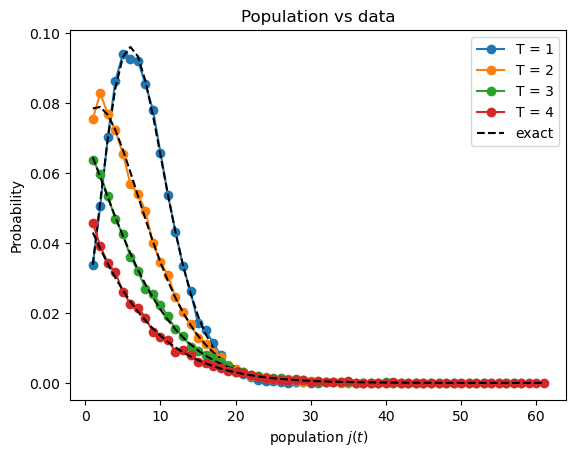

In [21]:
# distribution of population
Tvs = [1,2,3,4]
first = True
for T in Tvs:
    dist = [int(j(T)) for j in js]
    dist = np.array(dist)
    counts = np.bincount(dist)
    jvals = range(1,max(dist)+1)
    jdist = counts[1:]/sum(counts)
    
    exact = [physP(N,j,T,beta,gamma) for j in jvals]
    plt.plot(jvals,jdist,marker = 'o',linestyle= None,label = 'T = {}'.format(T))
    if T == Tvs[-1]:
        plt.plot(jvals,exact,'k--',label = 'exact')
        first = False
    else:
        plt.plot(jvals,exact,'k--')
    
    
plt.xlabel(r'population $j(t)$')
plt.ylabel('Probability')
plt.title('Population vs data')
plt.legend()
plt.show()

# Time-dependent cumulants

### main forecasting step

In [67]:
Fmax = 500
force = BasicForecast(Tmax,N,beta,gamma,zeroB = False)
tt,fv,fd = FtptForecast(Tmax,beta,gamma+0.0001,N,Fmax = Fmax,normalize = False,force = force)

cc1 37.46707523566834


100%|█████████████████████████████████████████| 500/500 [00:15<00:00, 31.97it/s]


asymF 0.9977946886202557
asymA 1


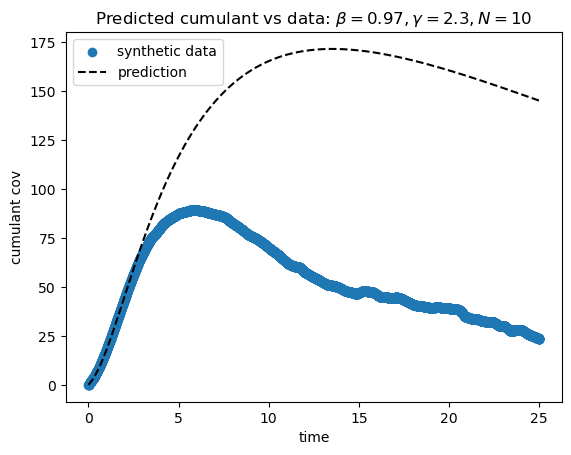

In [68]:
# Plot any cumulant vs time and compare with data
cumulant = 'cov'

tt = force['t']
data_interp  = np.interp(tt,trange,cumulant_data[cumulant])

plt.scatter(tt,data_interp,label = 'synthetic data')
plt.plot(tt,force[cumulant],'k--',label = 'prediction')


plt.title(r'Predicted cumulant vs data: $\beta = {},\gamma = {},N = {}$'.format(beta,gamma,N))
plt.xlabel("time")
plt.ylabel('cumulant {}'.format(cumulant))
# plt.xlim(0,5)
plt.legend()
plt.show()

## Determining B(t)

In [45]:
force0 = BasicForecast(Tmax,N,beta,gamma,zeroB = True)

cc1 37.46707523566834


In [70]:
asymavg = constC(N,beta,gamma,N)+N
print("Average asymptotic footprint:",asymavg)

Average asymptotic footprint: 40.96381008979856


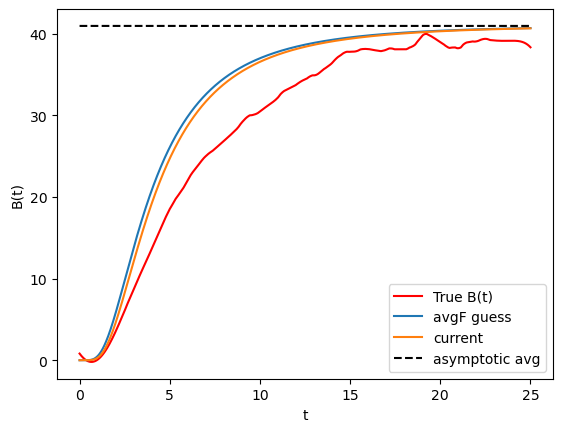

In [76]:
toplot = np.gradient((data_interp-force0[cumulant])/(np.exp((beta-1)*tt)*gamma),tt)
funcB = np.exp((beta-1)*tt)*toplot

funcB_smooth = savgol_filter(funcB, window_length=999, polyorder=5)


plt.plot(tt,funcB_smooth,label = 'True B(t)',color = 'red')
absorbs = absorbProb(tt,N,beta,gamma)

dabsorbs = np.gradient(absorbs,tt)

plt.plot(tt,absorbs*(force['F']),label = 'avgF guess')

plt.plot(tt,(force['F']-beta*force['j'])*absorbs,label = 'current')

plt.plot(tt,asymavg*np.ones(tt.shape),'k--',label = 'asymptotic avg')
# plt.xlim(0,5)
plt.ylabel("B(t)")
plt.xlabel('t')
plt.legend()
plt.show()

### footprint snapshot

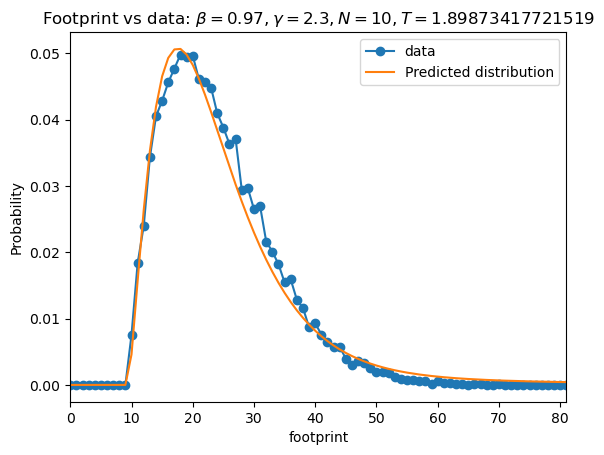

In [77]:
# distribution of footprints
T =2
c0 = np.argmin(np.abs(trange-T))
tval = trange[c0]

data_fvals = full_data[c0]['fv']
data_fdist = full_data[c0]['fd']

c1 = np.argmin(np.abs(tt-tval))

f_dist = fd[c1]

plt.plot(data_fvals,data_fdist,marker = 'o',linestyle= None,label = 'data')

plt.plot(fv,f_dist,label = "Predicted distribution")

plt.xlabel('footprint')
plt.ylabel('Probability')
plt.title(r'Footprint vs data: $\beta = {},\gamma = {},N = {},T = {}$'.format(beta,gamma,N,tval))
plt.legend()
plt.xlim(0,max(data_fvals))
plt.show()


## Animated footprint dist

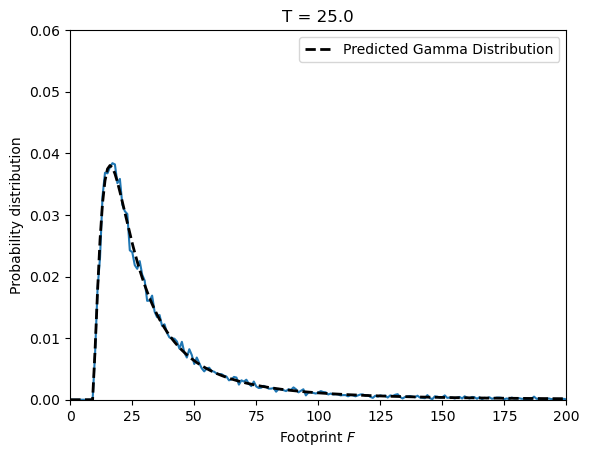

In [78]:
# Set up the figure, the axis, and the plot elements
fig, ax = plt.subplots()

ydata = full_data[0]['fd']
xdata = full_data[0]['fv']
ln, = plt.plot(xdata, ydata);

fit, = plt.plot(fv, fd[0], 'k--', lw=2, label='Predicted Gamma Distribution')

ax.set_xlabel(r"Footprint $F$")
ax.set_ylabel(r"Probability distribution")
plt.legend()

def init():
    ax.set_ylim(0, 0.06)
    ax.set_xlim(0, 200)
    return ln,

def update(frame):
    ydata = full_data[frame]['fd']
    xdata = full_data[frame]['fv']
    
    ln.set_data(xdata, ydata)
    time = trange[frame]
    ax.set_title("T = {}".format(time))
    
    closest = np.argmin(np.abs(tt-time))
    fit.set_data(fv,fd[closest])
        
    return ln,fit,

ani = FuncAnimation(fig, update, frames=range(1,nframes), init_func=init, blit=True);

HTML(ani.to_jshtml())

## KL Divergence over time

In [79]:
# construct prediction, data
exact_FDs = []
data_FDs = []
epsilon= 0.00001
for frame in range(1,nframes):
    
    tval = trange[frame]
    closest = np.argmin(np.abs(tt-tval))
    
    arr = fd[closest] # construct prediction
    arr[arr == np.inf] = 0
    exact_FDs.append(arr+epsilon)
    
    arr = np.zeros(Fmax) # construct data, padded for shape
    ddist = full_data[frame]['fd'][:Fmax]
    arr[:len(ddist)] = np.array(ddist)
    data_FDs.append(arr+epsilon)
    
exact_FDs = np.array(exact_FDs)
data_FDs = np.array(data_FDs)

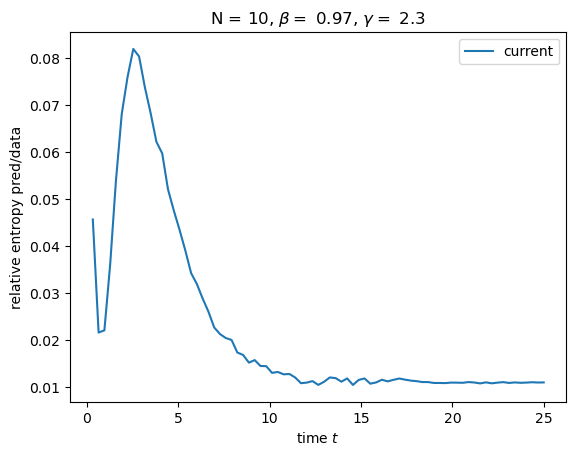

In [80]:
divs = [entropy(exact_FDs[frm-1],qk= data_FDs[frm-1]) for frm in range(1,nframes)]
plt.plot(trange[1:],divs,label = 'current')
plt.ylabel('relative entropy pred/data')
plt.xlabel(r'time $t$')
plt.title(r'N = {}, $\beta =$ {}, $\gamma =$ {}'.format(N,beta,gamma))
plt.legend()
plt.show()

## Time-dep burn probability

In [81]:
def data_EscapeProb(t,J):
    fvals = np.array([F(t) for F in Fs])
    escaped = (fvals >= J)
    return sum(escaped)/len(fvals)

In [82]:
threshold = 40
data_escapes = [data_EscapeProb(t,threshold) for t in tqdm(trange)]

100%|███████████████████████████████████████████| 80/80 [00:26<00:00,  2.98it/s]


In [83]:
pred_escapes = [1-sum(fd[i][:threshold]) for i in range(len(tt))]

In [84]:
pred_escapes[-1],data_escapes[-1],BurnProb(N,threshold,beta,gamma)

(0.2864251071207271, 0.28795, 0.2759300203826708)

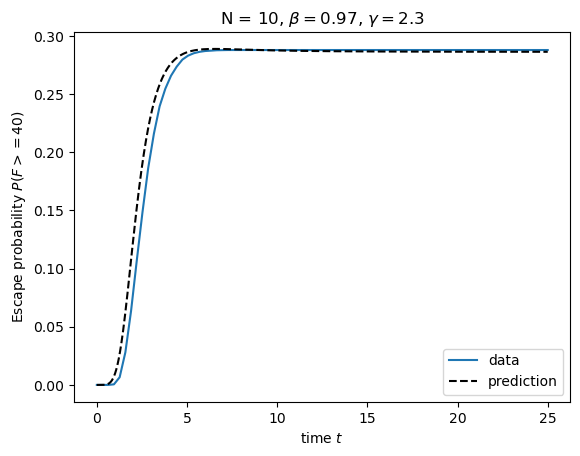

In [86]:
plt.plot(trange,data_escapes,label = 'data')
plt.plot(tt,np.array(pred_escapes),'k--',label = 'prediction')
plt.legend()
plt.xlabel(r'time $t$')
plt.ylabel(r'Escape probability $P(F >= {})$'.format(threshold))
plt.title(r'N = {}, $\beta =${}, $\gamma =${}'.format(N,beta,gamma))
# plt.xlim(0,7)
plt.show()